# 16 - Régression sur Discontinuité

Nous n'y pensons pas souvent, mais il est impressionnant de voir à quel point la nature est fluide. Vous ne pouvez pas faire pousser un arbre sans d'abord obtenir un bourgeon, vous ne pouvez pas vous téléporter d'un endroit à un autre, une plaie met du temps à guérir. Même dans le domaine social, la fluidité semble être la norme. Vous ne pouvez pas faire prospérer une entreprise en un jour, il faut de la constance et du travail acharné pour bâtir une fortune, et il faut des années avant de maîtriser la régression linéaire. Dans des circonstances normales, la nature est très cohérente et ne change pas brusquement.

> Quand l'âme intelligente et l'âme animale sont tenues ensemble dans une même étreinte, elles peuvent être empêchées de se séparer.

\- Tao Te Ching, Lao Tzu.

Ce qui signifie que **lorsque nous observons des sauts et des pics, ils sont probablement artificiels** et souvent dus à des situations créées par l'homme. Ces événements sont généralement accompagnés de contrefactuels par rapport à la manière normale des choses : si un événement étrange se produit, cela nous donne un aperçu de ce qui se serait passé si la nature fonctionnait différemment. Explorer ces sauts artificiels est au cœur de la régression sur discontinuité.

![img](./data/img/rdd/smooth.png)

Le cadre de base est le suivant. Imaginez que vous avez une variable de traitement $T$ et des résultats potentiels $Y_0$ et $Y_1$. Le traitement $T$ est une fonction discontinue d'une variable observée $R$ telle que

$$
D_i = \mathcal{1}\{R_i>c\}
$$

En d'autres termes, cela signifie que le traitement est nul lorsque $R$ est en dessous d'un seuil $c$ et égal à un sinon. Cela signifie que nous observons $Y_1$ lorsque $R>c$ et $Y_0$ lorsque $R<c$. Pour bien comprendre cela, imaginez les résultats potentiels comme deux fonctions que nous ne pouvons pas observer entièrement. Les deux fonctions $Y_0(R)$ et $Y_1(R)$ existent, mais nous ne pouvons pas les voir en entier. Le seuil agit comme un interrupteur qui nous permet de voir l'une ou l'autre de ces fonctions, mais jamais les deux, comme dans l'image ci-dessous :

![img](./data/img/rdd/rdd.png)

L'idée de la régression sur discontinuité est de comparer les résultats juste au-dessus et juste en dessous du seuil pour identifier l'effet du traitement au seuil. Cela s'appelle un **RD sharp (net)**, puisque la probabilité de recevoir le traitement passe de 0 à 1 au seuil, mais on pourrait aussi envisager un **RD fuzzy (flou)**, où la probabilité augmente également, mais de manière moins drastique.

## L'alcool vous tue-t-il ?

Une question de politique publique très pertinente est celle de l'âge minimal pour consommer de l'alcool. La plupart des pays, y compris le Brésil, le fixent à 18 ans, mais aux États-Unis (dans la plupart des États), il est actuellement de 21 ans. Alors, est-ce que les États-Unis sont trop prudents et devraient abaisser leur âge minimal pour boire de l'alcool ? Ou bien, est-ce que les autres pays devraient relever leur âge légal pour boire de l'alcool ?

Une façon d'aborder cette question est de la considérer sous l'angle du [taux de mortalité (Carpenter et Dobkin, 2009)](https://www.aeaweb.org/articles?id=10.1257/app.1.1.164). Du point de vue de la politique publique, on pourrait soutenir que nous devrions réduire le taux de mortalité autant que possible. Si la consommation d'alcool augmente considérablement le taux de mortalité, nous devrions éviter d'abaisser l'âge minimum pour boire de l'alcool. Cela serait cohérent avec l'objectif de réduire les décès causés par la consommation d'alcool.

Pour estimer les impacts de l'alcool sur la mortalité, nous pourrions utiliser le fait que l'âge légal pour boire impose une discontinuité à la nature. Aux États-Unis, les personnes juste en dessous de 21 ans ne boivent pas (ou beaucoup moins), tandis que celles un peu plus âgées boivent. Cela signifie que la probabilité de consommer de l'alcool augmente brusquement à 21 ans, et c'est quelque chose que nous pouvons explorer avec une régression sur discontinuité.

```note
On pourrait aussi soutenir que le fait de fêter ses 21 ans augmente la probabilité de consommer de l'alcool, car il est possible de le faire avant cet âge, même si ce n'est pas légalement. Cela ferait techniquement de cette situation un cas de régression sur discontinuité fuzzy (floue), ce que nous explorerons plus tard dans ce chapitre.
```

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

%matplotlib inline

style.use("fivethirtyeight")

Pour ce faire, nous pouvons récupérer des données sur la mortalité agrégées par âge. Chaque ligne représente l'âge moyen d'un groupe de personnes ainsi que la mortalité moyenne pour toutes causes confondues (`all`), par accident de la route (`mva`) et par suicide (`suicide`).

In [2]:
drinking = pd.read_csv("./data/drinking.csv")
drinking.head()[["agecell", "all", "mva", "suicide"]]

,agecell,all,mva,suicide
0,19.068493,92.825400,35.829327,11.203714
1,19.150684,95.100740,35.639256,12.193368
2,19.232876,92.144295,34.205650,11.715812
3,19.315070,88.427760,32.278957,11.275010
4,19.397260,88.704940,32.650967,10.984314


Pour faciliter la visibilité (et pour une autre raison importante que nous verrons plus tard), nous allons centrer la variable explicative `agecell` autour du seuil de 21 ans.

In [3]:
drinking["agecell"] -= 21

Si nous traçons les différentes variables de résultat (`all`, `mva`, `suicide`) en fonction de la variable explicative sur l'axe des x, nous obtenons une indication visuelle d'un certain saut dans la mortalité lorsque nous franchissons l'âge légal pour boire de l'alcool.

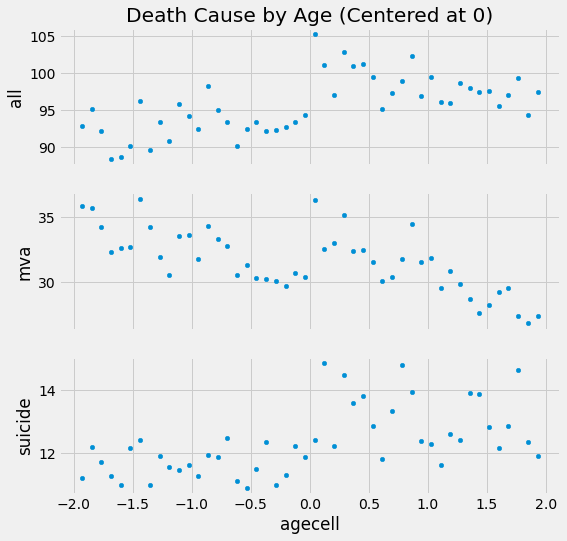

In [4]:
plt.figure(figsize=(8,8))
ax = plt.subplot(3,1,1)
drinking.plot.scatter(x="agecell", y="all", ax=ax)
plt.title("Death Cause by Age (Centered at 0)")

ax = plt.subplot(3,1,2, sharex=ax)
drinking.plot.scatter(x="agecell", y="mva", ax=ax)

ax = plt.subplot(3,1,3, sharex=ax)
drinking.plot.scatter(x="agecell", y="suicide", ax=ax);


Il y a quelques indices, mais nous avons besoin de plus que cela. Quel est exactement l'effet de la consommation d'alcool sur la mortalité au seuil ? Et quelle est l'erreur standard de cette estimation ?

## Estimation de la Régression sur Discontinuité (RDD)

L'hypothèse clé sur laquelle repose la RDD est la continuité des résultats potentiels au seuil. Formellement, les limites des résultats potentiels lorsque la variable explicative approche du seuil par la droite et par la gauche doivent être identiques.

$$
\lim_{r \to c^-} E[Y_{ti}|R_i=r] = \lim_{r \to c^+} E[Y_{ti}|R_i=r]
$$

Si cela est vrai, nous pouvons déterminer l'effet causal au seuil

$$
\begin{align}
\lim_{r \to c^+} E[Y_{ti}|R_i=r] - \lim_{r \to c^-} E[Y_{ti}|R_i=r]=&\lim_{r \to c^+} E[Y_{1i}|R_i=r] - \lim_{r \to c^-} E[Y_{0i}|R_i=r] \\
=& E[Y_{1i}|R_i=r] - E[Y_{0i}|R_i=r] \\
=& E[Y_{1i} - Y_{0i}|R_i=r]
\end{align}
$$

C'est, en quelque sorte, une sorte d'Effet de Traitement Moyen Local (LATE, *Local Average Treatement Effect* en anglais), puisque nous ne pouvons le connaître qu'au seuil. Dans ce contexte, nous pouvons considérer la RDD comme un essai randomisé local. Pour ceux qui se trouvent au seuil, le traitement pourrait aller dans un sens ou dans l'autre, et par hasard, certaines personnes se retrouvent en dessous du seuil, et d'autres au-dessus. Dans notre exemple, à un moment donné, certaines personnes ont juste plus de 21 ans, et d'autres ont juste moins de 21 ans. Ce qui détermine cela, c'est si quelqu'un est né quelques jours plus tard ou non, ce qui est assez aléatoire. Pour cette raison, la RDD fournit une histoire causale très convaincante. Ce n'est pas le standard en or des ECR (essais cliniques randomisés), mais c'est proche.

Maintenant, pour estimer l'effet du traitement au seuil, tout ce que nous devons faire est d'estimer les deux limites dans la formule ci-dessus et de les comparer. La façon la plus simple de le faire est de réaliser une régression linéaire.

![img](./data/img/rdd/ols.png)

Pour que cela fonctionne, nous interagissons une variable binaire indiquant si l'on se trouve au-dessus du seuil avec la variable explicative

$$
y_i = \beta_0 + \beta_1 r_i + \beta_2 \mathcal{1}\{r_i>c\} + \beta_3 \mathcal{1}\{r_i>c\} r_i
$$

Essentiellement, cela revient à ajuster une régression linéaire au-dessus du seuil et une autre en dessous. Le paramètre $\beta_0$ est l'ordonnée à l'origine de la régression en dessous du seuil et $\beta_0+\beta_2$ est l'ordonnée à l'origine pour la régression au-dessus du seuil.

C'est ici que le truc consistant à centrer la variable explicative sur le seuil entre en jeu. Après cette étape de prétraitement, le seuil devient zéro. Cela fait en sorte que l'ordonnée à l'origine $\beta_0$ soit la valeur prédite au seuil pour la régression en dessous de celui-ci. En d'autres termes, $\beta_0=\lim_{r \to c^-} E[Y_{ti}|R_i=r]$. Pour la même raison, $\beta_0+\beta_2$ est la limite du résultat au-dessus. Ce qui signifie que

$$
\lim_{r \to c^+} E[Y_{ti}|R_i=r] - \lim_{r \to c^-} E[Y_{ti}|R_i=r]=\beta_2=E[ATE|R=c]
$$

Voici à quoi cela ressemble en code pour le cas où nous voulons estimer l'effet de la consommation d'alcool sur les décès toutes causes confondues à 21 ans.

In [5]:
rdd_df = drinking.assign(threshold=(drinking["agecell"] > 0).astype(int))

model = smf.wls("all~agecell*threshold", rdd_df).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,93.6184,0.932,100.399,0.000,91.739,95.498
agecell,0.8270,0.819,1.010,0.318,-0.823,2.477
threshold,7.6627,1.319,5.811,0.000,5.005,10.320
agecell:threshold,-3.6034,1.158,-3.111,0.003,-5.937,-1.269


Ce modèle nous indique que la mortalité augmente de 7,6627 points avec la consommation d'alcool. En d'autres termes, l'alcool augmente les chances de décès par toutes causes confondues de 8 % (100 * ((7,6627 + 93,6184) / 93,6184 - 1)). Remarquez que cela nous donne également des erreurs standards pour notre estimation de l'effet causal. Dans ce cas, l'effet est statistiquement significatif, car la valeur p est inférieure à 0,01.

Si nous voulons vérifier ce modèle visuellement, nous pouvons afficher les valeurs prédites sur les données que nous avons. Vous pouvez voir qu'il semble que nous ayons deux modèles de régression : un pour ceux au-dessus du seuil et un pour ceux en dessous.

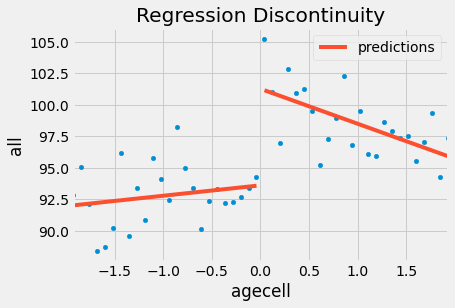

In [6]:
ax = drinking.plot.scatter(x="agecell", y="all", color="C0")
drinking.assign(predictions=model.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
plt.title("Regression Discontinuity");

Si nous faisons le même pour les autres causes, voici ce que nous obtenons :

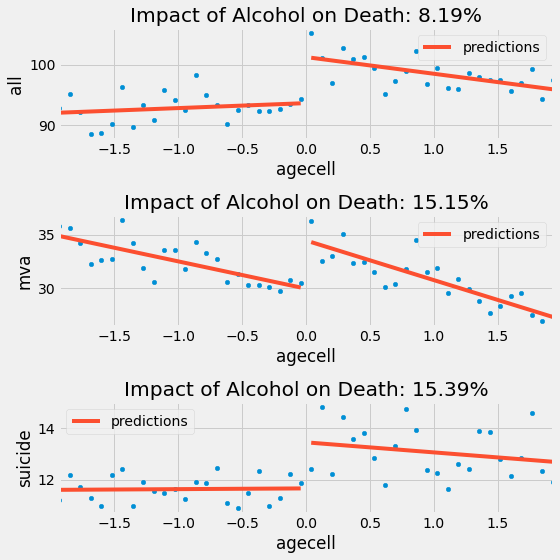

In [7]:
plt.figure(figsize=(8,8))

for p, cause in enumerate(["all", "mva", "suicide"], 1):
    ax = plt.subplot(3,1,p)
    drinking.plot.scatter(x="agecell", y=cause, ax=ax)
    m = smf.wls(f"{cause}~agecell*threshold", rdd_df).fit()
    ate_pct = 100*((m.params["threshold"] + m.params["Intercept"])/m.params["Intercept"] - 1)
    drinking.assign(predictions=m.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
    plt.title(f"Impact of Alcohol on Death: {np.round(ate_pct, 2)}%")

plt.tight_layout()

La régression sur discontinuité (RDD) nous indique que l'alcool augmente les chances de décès par suicide et par accident de voiture de 15 %, ce qui est une augmentation assez significative. Ces résultats constituent des arguments convaincants pour ne pas abaisser l'âge légal pour consommer de l'alcool, si notre objectif est de minimiser les taux de mortalité.

### Pondération par Kernel

La régression sur discontinuité repose fortement sur les propriétés d'extrapolation de la régression linéaire. Comme nous examinons les valeurs au début et à la fin de deux lignes de régression, il est crucial d'obtenir correctement ces limites. Ce qui peut se produire, c'est que la régression se concentre trop sur l'ajustement des autres points de données au détriment d'un mauvais ajustement au seuil. Si cela se produit, nous pourrions obtenir une mesure incorrecte de l'effet du traitement.

Une façon de résoudre ce problème est de donner un poids plus élevé aux points qui sont plus proches du seuil. Il existe de nombreuses façons de faire cela, mais une méthode populaire consiste à réajuster les échantillons à l'aide du **kernel triangulaire**.

$$
K(R, c, h) = \mathcal{1}\{|R-c| \leq h\} * \bigg(1-\frac{|R-c|}{h}\bigg)
$$

La première partie de ce kernel est une fonction indicatrice qui détermine si nous sommes proches du seuil. À quelle distance ? Cela est déterminé par un paramètre de largeur de bande $h$. La deuxième partie de ce kernel est une fonction de pondération. À mesure que nous nous éloignons du seuil, les poids deviennent de plus en plus petits. Ces poids sont divisés par la largeur de bande. Si la largeur de bande est grande, les poids diminuent plus lentement. Si la largeur de bande est petite, les poids chutent rapidement à zéro.

Pour faciliter la compréhension, voici à quoi ressemblent les poids pour ce kernel appliqué à notre problème. J'ai fixé la largeur de bande à 1 ici, ce qui signifie que nous ne prendrons en compte que les données des personnes âgées de 20 à 22 ans.

In [8]:
def kernel(R, c, h):
    indicator = (np.abs(R-c) <= h).astype(float)
    return indicator * (1 - np.abs(R-c)/h)

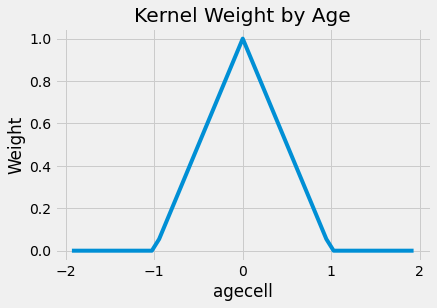

In [9]:
plt.plot(drinking["agecell"], kernel(drinking["agecell"], c=0, h=1))
plt.xlabel("agecell")
plt.ylabel("Weight")
plt.title("Kernel Weight by Age");

Si nous appliquons ces poids à notre problème initial, l'impact de l'alcool devient plus important, du moins pour toutes les causes confondues. Il passe de 7,6627 à 9,7004. Le résultat reste très significatif. De plus, remarquez que j'utilise `wls` au lieu de `ols`.

In [10]:
model = smf.wls("all~agecell*threshold", rdd_df,
                weights=kernel(drinking["agecell"], c=0, h=1)).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,93.2002,0.731,127.429,0.000,91.726,94.674
agecell,0.4109,1.789,0.230,0.819,-3.196,4.017
threshold,9.7004,1.034,9.378,0.000,7.616,11.785
agecell:threshold,-7.1759,2.531,-2.835,0.007,-12.276,-2.075


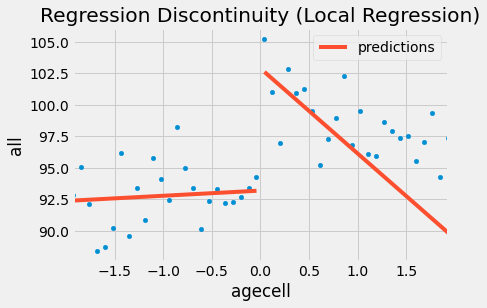

In [11]:
ax = drinking.plot.scatter(x="agecell", y="all", color="C0")
drinking.assign(predictions=model.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
plt.title("Regression Discontinuity (Local Regression)");

Et voici à quoi cela ressemble pour les autres causes de décès. Remarquez comment la régression à droite a une pente plus négative, car elle ne prend pas en compte les points les plus à droite.

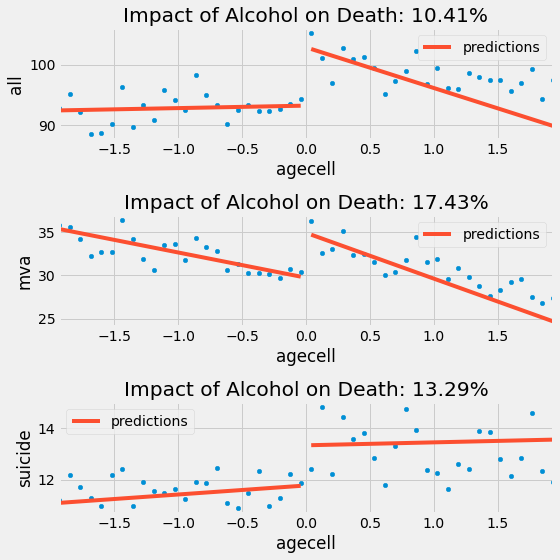

In [12]:
plt.figure(figsize=(8,8))
weights = kernel(drinking["agecell"], c=0, h=1)

for p, cause in enumerate(["all", "mva", "suicide"], 1):
    ax = plt.subplot(3,1,p)
    drinking.plot.scatter(x="agecell", y=cause, ax=ax)
    m = smf.wls(f"{cause}~agecell*threshold", rdd_df, weights=weights).fit()
    ate_pct = 100*((m.params["threshold"] + m.params["Intercept"])/m.params["Intercept"] - 1)
    drinking.assign(predictions=m.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
    plt.title(f"Impact of Alcohol on Death: {np.round(ate_pct, 2)}%")

plt.tight_layout()

À l'exception du suicide, il semble que l'ajout du poids du noyau ait amplifié l'impact négatif de l'alcool. Encore une fois, si nous voulons minimiser le taux de mortalité, nous ne devrions PAS recommander d'abaisser l'âge légal pour consommer de l'alcool, car il y a un impact clair de l'alcool sur les taux de mortalité.

Ce cas simple couvre ce qui se passe lorsque le design de régression sur discontinuité fonctionne parfaitement. Ensuite, nous verrons quelques diagnostics que nous devrions effectuer pour évaluer la fiabilité de la RDD et aborder un sujet qui nous tient particulièrement à cœur : l'effet de l'éducation sur les revenus.

## Effet Sheepskin et Fuzzy RDD

En ce qui concerne l'effet de l'éducation sur les revenus, il existe deux grandes perspectives en économie. La première est l'argument largement répandu selon lequel l'éducation augmente le capital humain, ce qui accroît la productivité et donc les revenus. Selon cette perspective, l'éducation vous transforme réellement pour le mieux. Une autre perspective est que l'éducation n'est qu'un mécanisme de signalisation. Elle vous soumet à des tests difficiles et à des tâches académiques. Si vous réussissez, cela signale au marché que vous êtes un bon employé. De cette manière, l'éducation ne vous rend pas plus productif. Elle indique simplement au marché à quel point vous avez toujours été productif. Ce qui compte ici, c'est le diplôme. Si vous l'avez, vous serez mieux payé. On appelle cela l'**effet sheepskin**, car les diplômes étaient autrefois imprimés sur de la peau de mouton.

Pour tester cette hypothèse, [Clark et Martorell](https://faculty.smu.edu/millimet/classes/eco7321/papers/clark%20martorell%202014.pdf) ont utilisé la régression sur discontinuité pour mesurer l'effet de l'obtention du diplôme de terminale sur les revenus. Pour ce faire, ils ont dû réfléchir à une variable explicative où les étudiants qui se trouvent au-dessus du seuil obtiennent leur diplôme et ceux qui se trouvent en dessous ne l'obtiennent pas. Ils ont trouvé de telles données dans le système éducatif du Texas.

Pour obtenir son diplôme au Texas, il faut réussir un examen. Les tests commencent en classe de seconde, et les étudiants peuvent les passer plusieurs fois, mais, finalement, ils doivent passer un examen de dernière chance à la fin de la terminale. L'idée était de recueillir des données sur les étudiants qui ont passé ces examens de dernière chance et de comparer ceux qui ont échoué de justesse à ceux qui ont réussi de justesse. Ces étudiants auront un capital humain très similaire, mais des qualifications de signalisation différentes. En effet, ceux qui ont réussi de justesse recevront un diplôme.

In [13]:
sheepskin = pd.read_csv("./data/sheepskin.csv")[["avgearnings", "minscore", "receivehsd", "n"]]
sheepskin.head()

,avgearnings,minscore,receivehsd,n
0,11845.086,-30.0,0.416667,12
1,9205.679,-29.0,0.387097,31
2,8407.745,-28.0,0.318182,44
3,11114.087,-27.0,0.377778,45
4,10814.624,-26.0,0.306667,75


Encore une fois, ces données sont regroupées par la variable explicative. Elles contiennent non seulement la variable explicative (minscore, déjà centrée sur zéro) et le résultat (avgearnings), mais elles incluent également la probabilité d'obtenir un diplôme dans cette tranche de score et la taille de l'échantillon (n). Par exemple, parmi les 12 étudiants situés dans la tranche de score -30 en dessous du seuil de réussite, seuls 5 ont pu obtenir le diplôme (12 * 0,416).

Cela signifie qu'il y a un certain décalage dans l'attribution du traitement. Certains étudiants qui sont en dessous du seuil de réussite ont quand même réussi à obtenir leur diplôme. Ici, la régression sur discontinuité est **fuzzy**, plutôt que nette. Remarquez comment la probabilité d'obtenir le diplôme ne passe pas de zéro à un au seuil. Mais elle passe tout de même de quelque chose comme 50 % à 90 %.

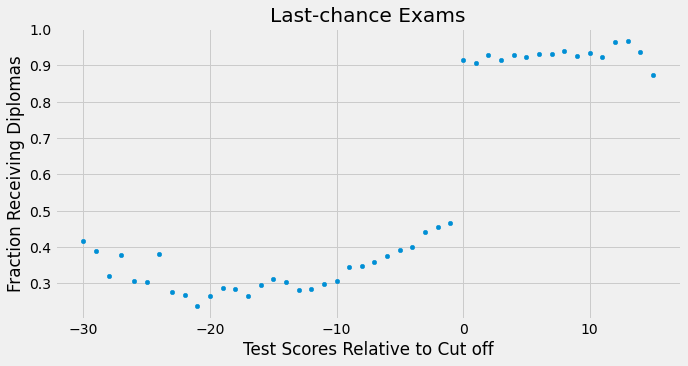

In [14]:
sheepskin.plot.scatter(x="minscore", y="receivehsd", figsize=(10,5))
plt.xlabel("Test Scores Relative to Cut off")
plt.ylabel("Fraction Receiving Diplomas")
plt.title("Last-chance Exams");

Nous pouvons considérer la régression sur discontinuité fuzzy comme une forme de non-respect du traitement. Franchir le seuil devrait permettre à tout le monde de recevoir le diplôme, mais certains étudiants, les "never takers" (ceux qui ne prennent jamais), ne l'obtiennent pas. De même, être en dessous du seuil devrait vous empêcher d'obtenir un diplôme, mais certains étudiants, les "always takers" (ceux qui prennent toujours), réussissent à l'obtenir quand même.

Tout comme dans le cas des résultats potentiels, nous avons ici un statut de traitement potentiel. $T_1$ est le traitement que chacun aurait reçu s'il avait été au-dessus du seuil. $T_0$ est le traitement que chacun aurait reçu s'il avait été en dessous du seuil. Comme vous l'avez peut-être remarqué, nous pouvons considérer le **seuil comme une Variable Instrumentale (IV, *instrumental variable* en anglais)**. Comme dans le cas des IV, si nous estimons naïvement l'effet du traitement, il sera biaisé vers zéro.

![img](./data/img/rdd/rdd_fuzzy.png)

La probabilité que le traitement soit inférieur à un, même au-dessus du seuil, rend le résultat que nous observons inférieur au véritable résultat potentiel $Y_1$. De la même manière, le résultat que nous observons en dessous du seuil est supérieur au véritable résultat potentiel $Y_0$. Cela donne l'impression que l'effet du traitement au seuil est plus faible qu'il ne l'est en réalité, et nous devrons utiliser des techniques de IV pour corriger cela.

Tout comme nous avons supposé la continuité pour les résultats potentiels, nous faisons maintenant la même hypothèse pour le traitement potentiel. De plus, nous devons supposer la monotonie, comme dans le cas des IV. Si vous ne vous en souvenez pas, cela signifie que $T_{i1}>T_{i0} \ \forall i$. Cela signifie que franchir le seuil de gauche à droite n'augmente que votre chance d'obtenir un diplôme (ou qu'il n'y a pas de "détracteurs"). Avec ces deux hypothèses, nous avons un estimateur de Wald pour LATE.

$$
\dfrac{\lim_{r \to c^+} E[Y_i|R_i=r] - \lim_{r \to c^-} E[Y_i|R_i=r]}{\lim_{r \to c^+} E[T_i|R_i=r] - \lim_{r \to c^-} E[T_i|R_i=r]} = E[Y_{1i} - Y_{0i} | T_{1i} > T_{0i}, R_i=c]
$$

Remarquez que c'est une estimation locale dans deux sens. Premièrement, elle est locale car elle ne donne l'effet du traitement qu'au seuil $c$. C'est la localité de la RD. Deuxièmement, elle est locale car elle n'estime l'effet du traitement que pour les "compliers" (ceux qui respectent le traitement). C'est la localité de la IV.

Pour estimer cela, nous allons utiliser deux régressions linéaires. Le numérateur peut être estimé comme nous l'avons fait précédemment. Pour obtenir le dénominateur, il suffit de remplacer le résultat par le traitement. Mais d'abord, parlons d'un test de cohérence que nous devons effectuer pour nous assurer que nous pouvons faire confiance à nos estimations RDD.

### Le Test de McCrary

Un des éléments qui pourrait invalider notre argument RDD est si les personnes peuvent manipuler leur position par rapport au seuil. Dans l'exemple du "sheepskin", cela pourrait se produire si les étudiants juste en dessous du seuil trouvaient un moyen de contourner le système pour augmenter leur score de test juste un peu. Un autre exemple est celui où il faut être en dessous d'un certain niveau de revenu pour bénéficier d'une aide gouvernementale. Certaines familles pourraient réduire leur revenu exprès, juste pour être éligibles au programme.

Dans ce genre de situation, nous avons tendance à observer un phénomène appelé "bunching" (regroupement) dans la densité de la variable explicative. Cela signifie que nous aurons beaucoup d'entités juste au-dessus ou juste en dessous du seuil. Pour vérifier cela, nous pouvons tracer la fonction de densité de la variable explicative et voir s'il y a des pics autour du seuil. Dans notre cas, la densité est donnée par la colonne `n` dans nos données.

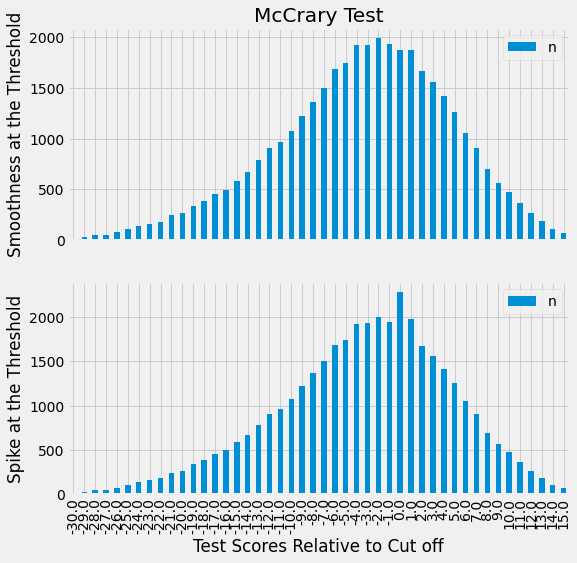

In [15]:
plt.figure(figsize=(8,8))

ax = plt.subplot(2,1,1)
sheepskin.plot.bar(x="minscore", y="n", ax=ax)
plt.title("McCrary Test")
plt.ylabel("Smoothness at the Threshold")

ax = plt.subplot(2,1,2, sharex=ax)
sheepskin.replace({1877:1977, 1874:2277}).plot.bar(x="minscore", y="n", ax=ax)
plt.xlabel("Test Scores Relative to Cut off")
plt.ylabel("Spike at the Threshold");

Le premier graphique montre à quoi ressemble la densité de nos données. Comme nous pouvons le voir, il n'y a pas de pics autour du seuil, ce qui signifie qu'il n'y a pas de regroupement. Les étudiants ne manipulent pas leur position par rapport au seuil. À titre d'illustration, le deuxième graphique montre à quoi ressemblerait un regroupement si les étudiants pouvaient manipuler leur position par rapport au seuil. Nous verrions un pic de densité pour les cellules juste au-dessus du seuil, car de nombreux étudiants se trouveraient dans cette cellule, réussissant de justesse l'examen.

Maintenant que cela est vérifié, nous pouvons revenir à l'estimation de l'effet "sheepskin". Comme je l'ai mentionné précédemment, le numérateur de l'estimateur de Wald peut être estimé comme nous l'avons fait dans le cas de la RD nette. Ici, nous utiliserons comme poids le noyau avec une largeur de bande de 15. Comme nous disposons également de la taille des cellules, nous multiplierons le noyau par la taille de l'échantillon pour obtenir un poids final pour chaque cellule.

In [16]:
sheepsking_rdd = sheepskin.assign(threshold=(sheepskin["minscore"]>0).astype(int))
model = smf.wls("avgearnings~minscore*threshold",
                sheepsking_rdd,
                weights=kernel(sheepsking_rdd["minscore"], c=0, h=15)*sheepsking_rdd["n"]).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.399e+04,83.678,167.181,0.000,1.38e+04,1.42e+04
minscore,181.6636,16.389,11.084,0.000,148.588,214.739
threshold,-97.7571,145.723,-0.671,0.506,-391.839,196.325
minscore:threshold,18.1955,30.311,0.600,0.552,-42.975,79.366


Cela nous indique que l'effet d'un diplôme est de -97,7571, mais ce résultat n'est pas statistiquement significatif (valeur P de 0,5). Si nous traçons ces résultats, nous obtenons une ligne très continue au niveau du seuil. Les personnes plus éduquées gagnent effectivement plus d'argent, mais il n'y a pas de saut au moment où elles obtiennent leur diplôme de terminale. Cela soutient l'argument selon lequel l'éducation augmente les revenus en rendant les gens plus productifs, plutôt que d'être simplement un signal pour le marché. En d'autres termes, il n'y a pas d'effet "sheepskin".

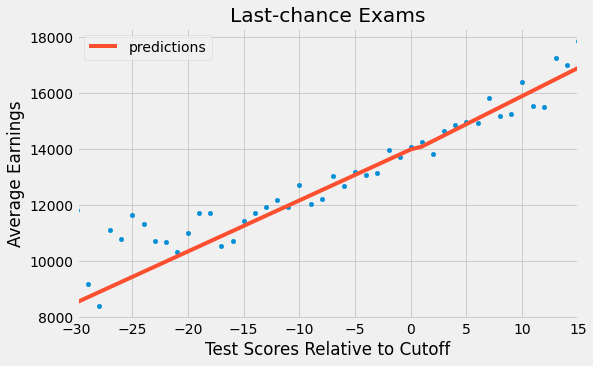

In [17]:
ax = sheepskin.plot.scatter(x="minscore", y="avgearnings", color="C0")
sheepskin.assign(predictions=model.fittedvalues).plot(x="minscore", y="predictions", ax=ax, color="C1", figsize=(8,5))
plt.xlabel("Test Scores Relative to Cutoff")
plt.ylabel("Average Earnings")
plt.title("Last-chance Exams");

Cependant, comme nous le savons grâce au fonctionnement du biais de non-conformité, ce résultat est biaisé vers zéro. Pour corriger cela, nous devons le redimensionner en utilisant la première étape et obtenir l'estimateur de Wald. Malheureusement, il n'existe pas de bonne implémentation en Python pour cela, nous devrons donc le faire manuellement et utiliser la méthode bootstrap pour obtenir les erreurs standards.

Le code ci-dessous exécute le numérateur de l'estimateur de Wald de la même manière que nous l'avons fait précédemment, et construit également le dénominateur en remplaçant la variable cible par la variable de traitement `receivehsd`. La dernière étape consiste simplement à diviser le numérateur par le dénominateur.

In [18]:
def wald_rdd(data):
    weights=kernel(data["minscore"], c=0, h=15)*data["n"]
    denominator = smf.wls("receivehsd~minscore*threshold", data, weights=weights).fit()
    numerator = smf.wls("avgearnings~minscore*threshold", data, weights=weights).fit()
    return numerator.params["threshold"]/denominator.params["threshold"]

In [19]:
from joblib import Parallel, delayed 

np.random.seed(45)
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(wald_rdd)(sheepsking_rdd.sample(frac=1, replace=True))
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

Avec les échantillons bootstrap, nous pouvons tracer la distribution des ATEs et voir où se situe l'intervalle de confiance à 95 %.

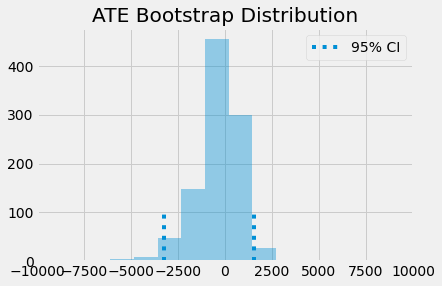

In [20]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 100, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 100, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.xlim([-10000, 10000])
plt.legend();

Comme vous pouvez le voir, même lorsque nous ajustons l'effet en utilisant la première étape, il n'est toujours pas statistiquement différent de zéro. Cela signifie que l'éducation n'augmente pas les revenus simplement par un effet "sheepskin", mais plutôt en augmentant la productivité de l'individu.

## Idées Clés

Nous avons appris à tirer parti des discontinuités artificielles pour estimer les effets causaux. L'idée est que nous aurons un seuil artificiel qui fait sauter la probabilité de recevoir le traitement. Un exemple que nous avons vu est la manière dont l'âge fait bondir la probabilité de consommer de l'alcool à 21 ans. Nous pourrions utiliser cela pour estimer l'impact de la consommation d'alcool sur le taux de mortalité. Nous utilisons le fait que, très près du seuil, nous avons quelque chose qui s'apparente à un essai randomisé. Les entités très proches du seuil auraient pu aller dans un sens ou dans l'autre, et ce qui détermine où elles se sont retrouvées est essentiellement aléatoire. Avec cela, nous pouvons comparer ceux juste au-dessus et juste en dessous pour obtenir l'effet du traitement. Nous avons vu comment nous pouvions le faire avec une régression linéaire pondérée en utilisant un noyau, ce qui nous a même donné, gratuitement, des erreurs standards pour notre ATE.

Ensuite, nous avons examiné ce qui se passe dans le design de RD floue, où il y a non-respect du traitement. Nous avons vu comment nous pouvions aborder la situation de manière similaire à ce que nous faisons avec les variables instrumentales.

## Références

J'aime penser à ce livre entier comme un hommage à Joshua Angrist, Alberto Abadie et Christopher Walters pour leur incroyable cours d'économétrie. La plupart des idées ici sont tirées de leurs cours à l'American Economic Association. Les regarder est ce qui me maintient sain d'esprit pendant cette année difficile de 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

Je tiens également à référencer les livres incroyables d'Angrist. Ils m'ont montré que l'économétrie, ou 'Metrics' comme ils l'appellent, n'est pas seulement extrêmement utile mais aussi profondément amusante.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

Ma dernière référence est le livre de Miguel Hernan et Jamie Robins. Il a été mon compagnon fidèle dans les questions causales les plus épineuses que j'ai dû résoudre.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

Les données utilisées ici proviennent d'une étude de Alpert, William T., Kenneth A. Couch, et Oskar R. Harmon. 2016. ["A Randomized Assessment of Online Learning"](https://www.aeaweb.org/articles?id=10.1257/aer.p20161057). American Economic Review, 106 (5): 378-82.

![img](./data/img/poetry.png)

## Contribuer

*L'Inférence Causale pour les Courageux et les Vrais* est un matériel open-source sur l'inférence causale, la statistique de la science. Son objectif est d'être accessible monétairement et intellectuellement. Il utilise uniquement des logiciels gratuits basés sur Python.
Si vous avez trouvé ce livre précieux et souhaitez le soutenir, veuillez vous rendre sur [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). Si vous n'êtes pas prêt à contribuer financièrement, vous pouvez également aider en corrigeant les fautes de frappe, en suggérant des modifications ou en donnant votre avis sur les passages que vous n'avez pas compris. Rendez-vous sur le repo du livre et [ouvrez une issue](https://github.com/matheusfacure/python-causality-handbook/issues). Enfin, si vous avez aimé ce contenu, veuillez le partager avec d'autres personnes qui pourraient le trouver utile et lui donner une [étoile sur GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).